# Pràctica 3: chinese_mnist

En aquest fitxer es presentara tot el codi utilitzat per fer la comparació dels models i fer una classificació numèrica de la base de dades.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import os
import matplotlib.image as mpimg

In [2]:
#Mostramos los archivos que tienen solo lectura de la carpeta

for dirname, _, filenames in os.walk('../Practica3APC-GKA06-15D-1330'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../Practica3APC-GKA06-15D-1330\chinese_mnist.csv
../Practica3APC-GKA06-15D-1330\chinese_mnist.ipynb
../Practica3APC-GKA06-15D-1330\chinese_mnist.tfrecords
../Practica3APC-GKA06-15D-1330\README.md
../Practica3APC-GKA06-15D-1330\.git\COMMIT_EDITMSG
../Practica3APC-GKA06-15D-1330\.git\config
../Practica3APC-GKA06-15D-1330\.git\description
../Practica3APC-GKA06-15D-1330\.git\FETCH_HEAD
../Practica3APC-GKA06-15D-1330\.git\HEAD
../Practica3APC-GKA06-15D-1330\.git\index
../Practica3APC-GKA06-15D-1330\.git\ORIG_HEAD
../Practica3APC-GKA06-15D-1330\.git\packed-refs
../Practica3APC-GKA06-15D-1330\.git\hooks\applypatch-msg.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\commit-msg.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\fsmonitor-watchman.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\post-update.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\pre-applypatch.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\pre-commit.sample
../Practica3APC-GKA06-15D-1330\.git\hooks\pre-merge-commit.sa

In [3]:
# Carreguem dataset
dataset = pd.read_csv('chinese_mnist.csv')
print("Dimensionalitat de la BBDD:", dataset.shape)
print("\nTabla de la BBDD:")
display(dataset)

Dimensionalitat de la BBDD: (15000, 5)

Tabla de la BBDD:


,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [4]:
#percentatges nulls
print(dataset.isnull().sum()/len(dataset)*100)

suite_id     0.0
sample_id    0.0
code         0.0
value        0.0
character    0.0
dtype: float64


In [5]:
#caracters de sortida:
sortides = dataset['character'].unique()
print(sortides)

['九' '十' '百' '千' '万' '亿' '零' '一' '二' '三' '四' '五' '六' '七' '八']


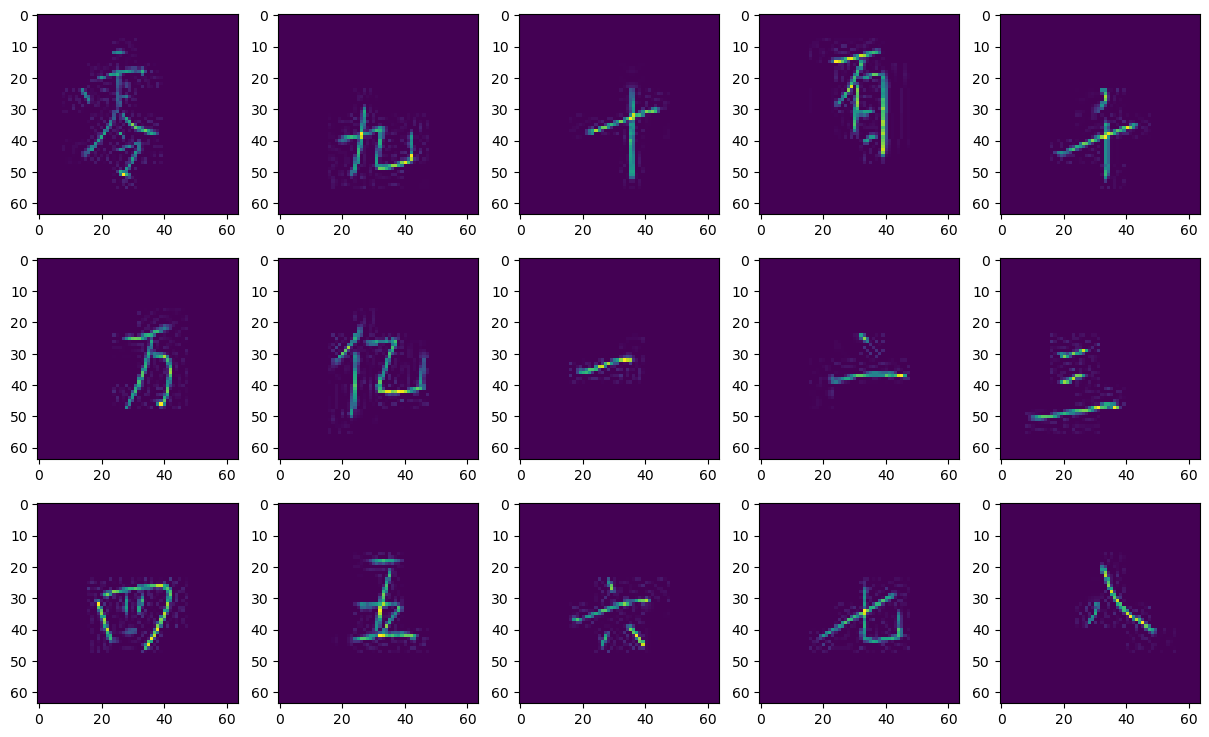

In [6]:
#Mostrar algunas imagenes con pyplot (las 15 primeras)
plt.figure(figsize=(15,9))

carpeta = 'data/data'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:15]):
  plt.subplot(3,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [7]:
def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
X = []
y = []
for row in dataset.itertuples():
    suite_id = row[1]
    sample_id = row[2]
    code = row[3]
    file_name = f"input_{suite_id}_{sample_id}_{code}.jpg"
    
    #Guarda la imagen
    img = cv2.imread(f"data/data/{file_name}")

    #Convierte a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Aplicamos threshold
    x = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)[1]
    X.append(x)

    #Hacemos one_hot encode
    one_hot = [0] * 15
    one_hot[code - 1] = 1
    y.append(one_hot)

X = np.array(X)

#salida One Hot Encoded
y = np.array(y)

#Salida sin One Hot Encoded
y_n = dataset['character']
x_n = X
#dataset One Hot Encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#dataset Normal
Xn_train, Xn_test, yn_train, yn_test = train_test_split(x_n, y_n, test_size=0.2, random_state=42)


In [9]:
print(Xn_train.shape)
print(yn_train.shape)
print(X_train.shape)
print(y_train.shape)

(12000, 64, 64)
(12000,)
(12000, 64, 64)
(12000, 15)


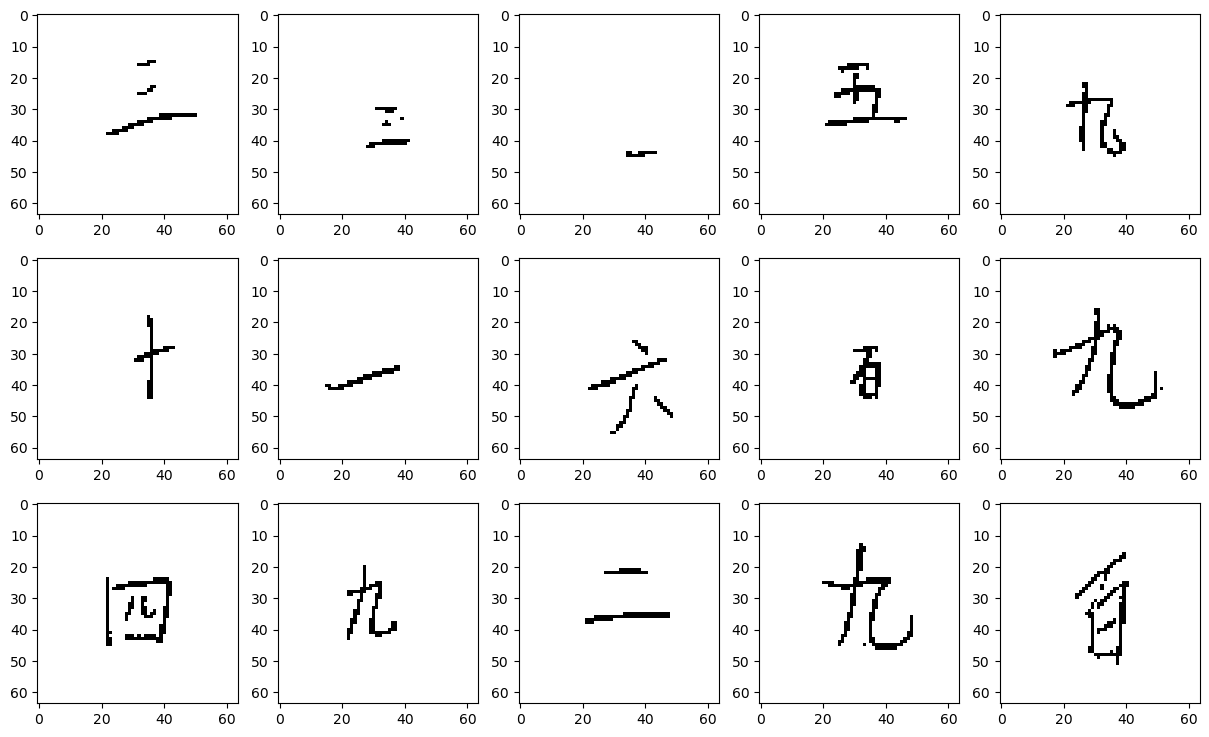

In [10]:
plt.figure(figsize=(15,9))
for i, imagen in enumerate(X_train[:15]):
    plt.subplot(3, 5,i+1)
    #Imprimim en blanc i negre
    #plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.imshow(imagen, cmap = plt.cm.binary)

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [12]:
#Crear el modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64,64,1]), #neuronas de entrada
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
#Compilar el modelo
modelo.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 50)                204850    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 15)                765       
                                                                 
Total params: 208,165
Trainable params: 208,165
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_base = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[64, 64, 1]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(15, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
model_base.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               524416    
                                                                 
 dense_4 (Dense)             (None, 15)                1935      
                                                                 
Total params: 526,351
Trainable params: 526,351
Non-trainable params: 0
_________________________________________________________________


In [14]:
historial1 = modelo.fit(X_train, y_train, epochs = 50)

Epoch 1/50
375/375 [==============================] - 2s 4ms/step - loss: 4.2592 - accuracy: 0.1629
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 2.2985 - accuracy: 0.2490
Epoch 3/50
375/375 [==============================] - 1s 4ms/step - loss: 2.0796 - accuracy: 0.3114
Epoch 4/50
375/375 [==============================] - 2s 6ms/step - loss: 1.9144 - accuracy: 0.3523
Epoch 5/50
375/375 [==============================] - 2s 6ms/step - loss: 1.7590 - accuracy: 0.3996
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 1.6699 - accuracy: 0.4243
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 1.5956 - accuracy: 0.4492
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 1.4983 - accuracy: 0.4733
Epoch 9/50
375/375 [==============================] - 1s 4ms/step - loss: 1.4160 - accuracy: 0.4955
Epoch 10/50
375/375 [==============================] - 2s 5ms/step - loss: 1.3681 - accuracy: 0.5153

In [15]:
historial2 = model_base.fit(X_train, y_train, epochs = 50)

Epoch 1/50
375/375 [==============================] - 2s 3ms/step - loss: 6.8336 - accuracy: 0.1891
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 2.1553 - accuracy: 0.2956
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 1.9006 - accuracy: 0.3634
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 1.7303 - accuracy: 0.4139
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 1.6165 - accuracy: 0.4490
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 1.5218 - accuracy: 0.4837
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 1.4343 - accuracy: 0.5067
Epoch 8/50
375/375 [==============================] - 2s 4ms/step - loss: 1.3672 - accuracy: 0.5264
Epoch 9/50
375/375 [==============================] - 2s 4ms/step - loss: 1.2887 - accuracy: 0.5542
Epoch 10/50
375/375 [==============================] - 1s 4ms/step - loss: 1.2546 - accuracy: 0.5694

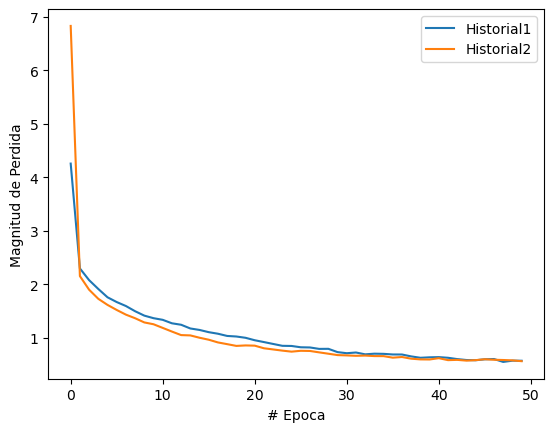

In [16]:
"""XOneHot_train = XOneHot_train.cache()
yOneHot_train = yOneHot_train.cache()
X_train = X_train.cache()
y_train = y_train.cache()


TAMANO_LOTE = 32
X_train = X_train.repeat
X_train = X_train.repeat().shuffle(12000).batch(TAMANO_LOTE)
y_test = y_test.batch(TAMANO_LOTE)"""

plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')

plt.plot(historial1.history['loss'],label='Historial1')
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')
plt.plot(historial2.history['loss'], label='Historial2')

plt.legend()